In [1]:
%cd C:/Users/ajunk/

C:\Users\ajunk


In [2]:
import tensorflow as tf
import PIL
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import decode_predictions
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import metrics, optimizers
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
import zipfile as zf
files = zf.ZipFile("moeimouto-faces_aug.zip", 'r')
files.extractall('directory to extract')
files.close()


In [4]:
%cd C:/Users/ajunk/directory to extract/

C:\Users\ajunk\directory to extract


In [5]:
train_dir = 'C:/Users/ajunk/directory to extract/moeimouto-faces/Train'
#validation_dir= '/content/drive/My Drive/Insight/moeimouto-faces/moeimouto-faces/Test'
test_dir = 'C:/Users/ajunk/directory to extract/moeimouto-faces/Test'

In [6]:
img_width, img_height = 96, 96      #200,200 does not work. 
batch_size = 128                     

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

train_datagen = ImageDataGenerator( 
    rescale=1. / 255, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True) 
  
test_datagen = ImageDataGenerator(rescale=1. / 255) 
  
train_generator = train_datagen.flow_from_directory( 
    train_dir, 
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical')  # removed color_mode='rgba' subset ='training'
  
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical') #subset ='validation'

Found 22329 images belonging to 173 classes.
Found 15035 images belonging to 173 classes.


In [7]:
# Inspect batch
sample_training_images, _ = next(train_generator)
label_map = (train_generator.class_indices)

In [8]:
#inspect batch for image size, class
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 96, 96, 3)
(128, 173)


In [9]:
from glob import glob
class_names = glob("*") # Reads all the folders in which images are present
class_names = sorted(class_names) # Sorting them
name_id_map = dict(zip(class_names, range(len(class_names))))
print(label_map)

{'Aika Granzchesta': 0, 'Aisaka Taiga': 1, 'Akihime Sumomo': 2, 'Akiyama Mio': 3, 'Akizuki Ritsuko': 4, 'Alice Margatroid': 5, 'Allen Walker': 6, 'Amami Haruka': 7, 'Ana Coppola': 8, 'Andou Mahoro': 9, 'Arcueid Brunestud': 10, 'Asagiri Mai': 11, 'Asahina Mikuru': 12, 'Asakura Otome': 13, 'Asakura Yume': 14, 'Ayanami Rei': 15, 'Ayasaki Hayate': 16, 'Belldandy': 17, 'Black Rock Shooter': 18, 'C.C': 19, 'Canal Volphied': 20, 'Caro Ru Lushe': 21, 'Chii': 22, 'Cirno': 23, 'Corticarte Apa Lagranges': 24, 'Daidouji Tomoyo': 25, 'Enma Ai': 26, 'Erio Mondial': 27, 'Fate Testarossa': 28, 'Feena Fam Earthlight': 29, 'Flandre Scarlet': 30, 'Fujibayashi Kyou': 31, 'Fukuzawa Yumi': 32, 'Furude Rika': 33, 'Furukawa Nagisa': 34, 'Fuyou Kaede': 35, 'Golden Darkness': 36, 'Hakurei Reimu': 37, 'Hatsune Miku': 38, 'Hayama Mizuki': 39, 'Hayase Mitsuki': 40, 'Hiiragi Kagami': 41, 'Hiiragi Tsukasa': 42, 'Hinamori Amu': 43, 'Hirasawa Yui': 44, 'Horo': 45, 'Houjou Reika': 46, 'Houjou Satoko': 47, 'Ibuki Fuuko'

In [10]:
# This function will plot images in the form of a grid with 1 row and 10 columns 
# where images are placed in each column
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(15,15))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

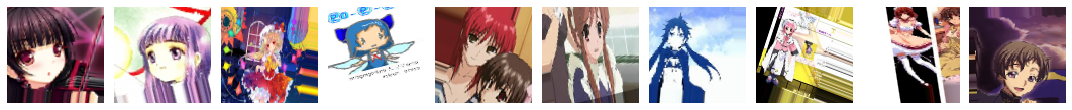

In [11]:
plotImages(sample_training_images[:10])

In [12]:
def model_output_for_TL (pre_trained_model, last_output):    
    x = layers.Flatten()(last_output)

    #Global pooling layer
    x = pre_trained_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Fully connected layer on top of last output
    x = layers.Dense(2048, activation='relu')(x) 
    x = layers.Dropout(0.2)(x)

    #Second connected layer
    x = layers.Dense(2048, activation='relu')(x) 
  
    # Output neuron
    #logistic layer for classification of 173 classes
    x = layers.Dense(173, activation='softmax')(x) #sigmoid is best for binary classification, softmax best for multiple classes
    
    model = Model(pre_trained_model.input, x)
    
    return model
    
    #base model
pre_trained_model = InceptionV3(input_shape = (img_width, img_height, 3), 
                                include_top = False, #load a network that doesn't include the classification layers at the top—ideal for feature extraction
                                weights = 'imagenet')

#make model nontrainable
for layer in pre_trained_model.layers:
  layer.trainable = False 

#feature extraction layer 7x7
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output
model_TL = model_output_for_TL(pre_trained_model, last_output)

In [13]:
model_TL.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 47, 47, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 47, 47, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 47, 47, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
# Define further metrics for model
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [15]:
from PIL import Image, ImageFile
from io import BytesIO

Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True

model_TL.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
history_TL = model_TL.fit(
      train_generator,
      steps_per_epoch=25,  
      epochs=60,
      verbose=1,
      validation_data = validation_generator)
tf.keras.models.save_model(model_TL,'my_model.hdf7') #train model in 60 epoch increments.

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 118 steps
Epoch 1/60
24/25 [===========================>..] - ETA: 1s - loss: 5.0832 - accuracy: 0.0160 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00

C:\Users\ajunk\Anaconda3\lib\site-packages\PIL\Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


25/25 [==============================] - 177s 7s/step - loss: 5.0727 - accuracy: 0.0160 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 5.2732 - val_accuracy: 0.0276 - val_f1_m: 1.2938e-04 - val_precision_m: 0.0028 - val_recall_m: 6.6208e-05
Epoch 2/60
25/25 [==============================] - 166s 7s/step - loss: 4.8222 - accuracy: 0.0188 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 4.7379 - val_accuracy: 0.0221 - val_f1_m: 0.0010 - val_precision_m: 0.0232 - val_recall_m: 5.2966e-04
Epoch 3/60
25/25 [==============================] - 176s 7s/step - loss: 4.7796 - accuracy: 0.0237 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 4.5266 - val_accuracy: 0.0286 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/60
25/25 [==============================] - 156s 6s/step - loss: 4.7656 - accuracy: 0.0272 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 

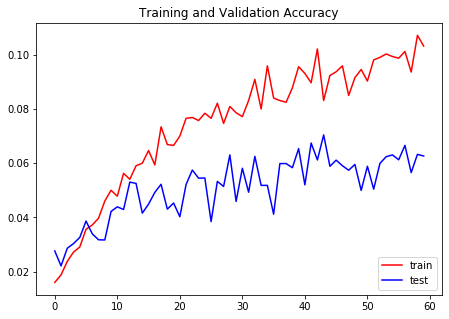

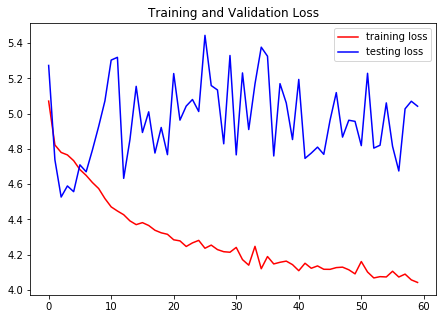

In [16]:
# develop an mlp for blobs dataset
from sklearn.datasets import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

# evaluate the model
#_, train_acc = model_TL.fit.evaluate(trainX, trainy, verbose=0)
#_, test_acc = model_TL.fit.evaluate(testX, testy, verbose=0)
#print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# learning curves of model accuracy
pyplot.figure(figsize=(16, 5))
pyplot.subplot(1, 2, 1)
pyplot.plot(history_TL.history['accuracy'], color="red", label='train')
pyplot.plot(history_TL.history['val_accuracy'], color="blue", label='test')
pyplot.legend(loc='lower right')
pyplot.title('Training and Validation Accuracy')
pyplot.show()

#learning curves of model loss
pyplot.figure(figsize=(16, 5))
pyplot.subplot(1, 2, 2)
pyplot.plot(history_TL.history['loss'], color="red", label='training loss')
pyplot.plot(history_TL.history['val_loss'], color="blue", label='testing loss')
pyplot.legend(loc='upper right')
pyplot.title('Training and Validation Loss')
pyplot.show()

In [18]:
#further tune the model
#Now freeze the first ~150 layers (hyperparameter to be tuned) and ‘unfreeze’ the rest of the layers to perform fine-tuning:

for layer in model_TL.layers[: 150]: 
  layer.trainable = False 

for layer in model_TL.layers[ 150:]: 
  layer.trainable = True

In [25]:
# re-train again 
# Set Optimizer
opt = tf.keras.optimizers.RMSprop(lr=0.0001)


model_TL.compile(optimizer = opt, 
               loss ='categorical_crossentropy',metrics=['accuracy', f1_m, precision_m, recall_m])
        
# we train our model again (fine-tuning)
# alongside the top Dense layers 
history_TL = model_TL.fit(
      train_generator,
      steps_per_epoch=25,  
      epochs=60,
      verbose=1,
      validation_data = validation_generator)
tf.keras.models.save_model(model_TL,'my_model.hdf7_retrained') 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 118 steps
Epoch 1/60
24/25 [===========================>..] - ETA: 3s - loss: 3.9001 - accuracy: 0.1139 - f1_m: 0.0190 - precision_m: 0.4498 - recall_m: 0.0098

C:\Users\ajunk\Anaconda3\lib\site-packages\PIL\Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


25/25 [==============================] - 207s 8s/step - loss: 3.8871 - accuracy: 0.1134 - f1_m: 0.0206 - precision_m: 0.4547 - recall_m: 0.0106 - val_loss: 4.6778 - val_accuracy: 0.0855 - val_f1_m: 0.0391 - val_precision_m: 0.1712 - val_recall_m: 0.0222
Epoch 2/60
25/25 [==============================] - 181s 7s/step - loss: 3.6657 - accuracy: 0.1513 - f1_m: 0.0504 - precision_m: 0.5565 - recall_m: 0.0266 - val_loss: 4.4302 - val_accuracy: 0.0952 - val_f1_m: 0.0432 - val_precision_m: 0.2096 - val_recall_m: 0.0242
Epoch 3/60
25/25 [==============================] - 181s 7s/step - loss: 3.4672 - accuracy: 0.1797 - f1_m: 0.0649 - precision_m: 0.5797 - recall_m: 0.0347 - val_loss: 4.3863 - val_accuracy: 0.1059 - val_f1_m: 0.0634 - val_precision_m: 0.2336 - val_recall_m: 0.0368
Epoch 4/60
25/25 [==============================] - 182s 7s/step - loss: 3.3502 - accuracy: 0.2059 - f1_m: 0.0887 - precision_m: 0.6172 - recall_m: 0.0481 - val_loss: 4.3147 - val_accuracy: 0.1143 - val_f1_m: 0.0725 

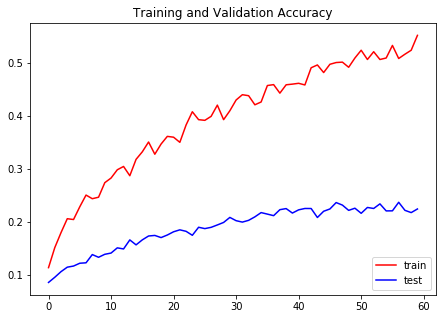

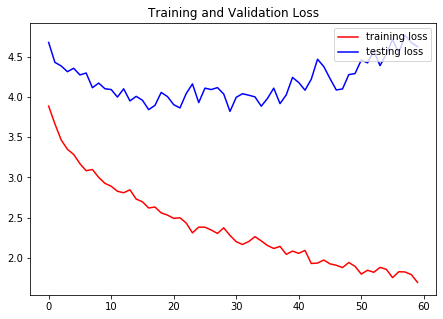

In [26]:
# Review the performance of tuned model
from sklearn.datasets import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

# evaluate the model
#_, train_acc = model_TL.fit.evaluate(trainX, trainy, verbose=0)
#_, test_acc = model_TL.fit.evaluate(testX, testy, verbose=0)
#print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# learning curves of model accuracy
pyplot.figure(figsize=(16, 5))
pyplot.subplot(1, 2, 1)
pyplot.plot(history_TL.history['accuracy'], color="red", label='train')
pyplot.plot(history_TL.history['val_accuracy'], color="blue", label='test')
pyplot.legend(loc='lower right')
pyplot.title('Training and Validation Accuracy')
pyplot.show()

#learning curves of model loss
pyplot.figure(figsize=(16, 5))
pyplot.subplot(1, 2, 2)
pyplot.plot(history_TL.history['loss'], color="red", label='training loss')
pyplot.plot(history_TL.history['val_loss'], color="blue", label='testing loss')
pyplot.legend(loc='upper right')
pyplot.title('Training and Validation Loss')
pyplot.show()

In [29]:
#further tune the model
#Now freeze the first ~250 layers (hyperparameter to be tuned) and ‘unfreeze’ the rest of the layers to perform fine-tuning:

for layer in model_TL.layers[: 250]: 
  layer.trainable = False 

for layer in model_TL.layers[ 250:]: 
  layer.trainable = True


In [30]:
# re-train again 
# Set Optimizer
opt = tf.keras.optimizers.RMSprop(lr=0.0001)


model_TL.compile(optimizer = opt, 
               loss ='categorical_crossentropy',metrics=['accuracy', f1_m, precision_m, recall_m])
        
# we train our model again (fine-tuning)
# alongside the top Dense layers 
history_TL = model_TL.fit(
      train_generator,
      steps_per_epoch=25,  
      epochs=75,
      verbose=1,
      validation_data = validation_generator)
tf.keras.models.save_model(model_TL,'my_model.hdf7_last_train') 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 25 steps, validate for 118 steps
Epoch 1/75
24/25 [===========================>..] - ETA: 1s - loss: 1.5223 - accuracy: 0.5986 - f1_m: 0.5966 - precision_m: 0.8390 - recall_m: 0.4635

C:\Users\ajunk\Anaconda3\lib\site-packages\PIL\Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


25/25 [==============================] - 172s 7s/step - loss: 1.5164 - accuracy: 0.6009 - f1_m: 0.5985 - precision_m: 0.8406 - recall_m: 0.4653 - val_loss: 4.9741 - val_accuracy: 0.2235 - val_f1_m: 0.2262 - val_precision_m: 0.3032 - val_recall_m: 0.1808
Epoch 2/75
25/25 [==============================] - 161s 6s/step - loss: 1.4823 - accuracy: 0.6012 - f1_m: 0.6114 - precision_m: 0.8355 - recall_m: 0.4828 - val_loss: 5.0749 - val_accuracy: 0.2246 - val_f1_m: 0.2273 - val_precision_m: 0.3020 - val_recall_m: 0.1826
Epoch 3/75
25/25 [==============================] - 162s 6s/step - loss: 1.5394 - accuracy: 0.5850 - f1_m: 0.5834 - precision_m: 0.8318 - recall_m: 0.4500 - val_loss: 5.2919 - val_accuracy: 0.2174 - val_f1_m: 0.2207 - val_precision_m: 0.2898 - val_recall_m: 0.1787
Epoch 4/75
25/25 [==============================] - 161s 6s/step - loss: 1.5568 - accuracy: 0.5750 - f1_m: 0.5827 - precision_m: 0.8199 - recall_m: 0.4538 - val_loss: 5.2490 - val_accuracy: 0.2161 - val_f1_m: 0.2202 

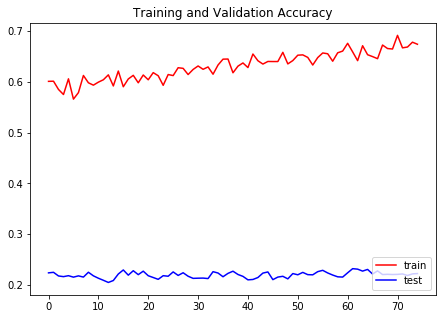

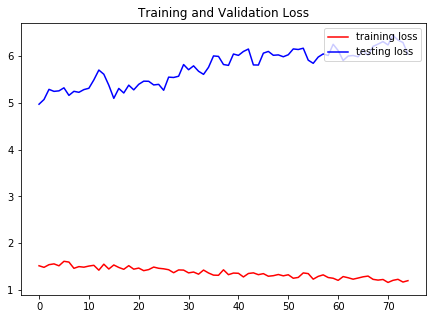

In [31]:
# Review the performance of tuned model
from sklearn.datasets import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

# evaluate the model
#_, train_acc = model_TL.fit.evaluate(trainX, trainy, verbose=0)
#_, test_acc = model_TL.fit.evaluate(testX, testy, verbose=0)
#print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# learning curves of model accuracy
pyplot.figure(figsize=(16, 5))
pyplot.subplot(1, 2, 1)
pyplot.plot(history_TL.history['accuracy'], color="red", label='train')
pyplot.plot(history_TL.history['val_accuracy'], color="blue", label='test')
pyplot.legend(loc='lower right')
pyplot.title('Training and Validation Accuracy')
pyplot.show()

#learning curves of model loss
pyplot.figure(figsize=(16, 5))
pyplot.subplot(1, 2, 2)
pyplot.plot(history_TL.history['loss'], color="red", label='training loss')
pyplot.plot(history_TL.history['val_loss'], color="blue", label='testing loss')
pyplot.legend(loc='upper right')
pyplot.title('Training and Validation Loss')
pyplot.show()